In [1]:
from os import chdir
chdir("../general")
from models import *
from observation import *
from util import *
chdir("../case-studies")

In [2]:
from fenics import *

import numpy as np
from numpy import random
from numpy import linalg as linalg
from scipy import sparse
from scipy import stats
from scipy.sparse import linalg as splinalg

from sksparse import cholmod as ch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from decimal import Decimal
import time

In [3]:
def pprint(num):
	print('%.2E' % Decimal(num))

In [4]:
start = time.time()
# Create mesh and define function space
xL = -10
xR = 20
expand = 5
num_pt = 150
mesh = IntervalMesh(num_pt,xL-expand,xR+expand)
V = FunctionSpace(mesh, 'P', 1)
fem = V.element()

In [5]:
# Define our source problem parameters
alpha = 4			  # twice the number of recursive applications
d = 1				  # dimension of the space
nu = alpha-d/2		  # matern nu parameter
kappa = 1   # matern kappa parameter
rho = np.sqrt(8*nu)/kappa # range
sigma2 = 10           # variance of the source
tau = 2               # time scale of the source
print(rho)

5.291502622129181


In [6]:
# Define our mechanics problem parameters
T = 100
diff = 0.25
diffusion = Constant(diff)
dec = 0.05
decay = Constant(dec)
advection = Expression("1 + 0.2*cos(6.283*x[0]/10) + 0.15*cos(9.425*x[0]/10) + 0.15*cos(15.708*x[0]/10)",degree=2,domain=mesh)
def adv(x):
	return 1 + 0.2*np.cos(6.283*x/10) + 0.15*cos(9.425*x/10) + 0.15*cos(15.708*x/10)
adv0 = str(adv(xL))
adv1 = str(adv(xR))
strL = "(" + str(xL) + ")"
strR = "(" + str(xR) + ")"
termL = "(" + strR + "-x[0])/(" + strR + "-" + strL + ")"
termR = "(x[0] - " + strL +")/(" + strR + "-" + strL + ")"
adv_BC = Expression("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR,degree=1,domain=mesh)

In [7]:
# Get the source problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = (kappa**2/tau)*u*v*dx + (1/tau)*inner(grad(u), grad(v))*dx # the diffusion term has flipped sign due to int-by-parts
mass = inner(u,v)*dx

In [8]:
# Assemble source matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K_source = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L_source = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL_source = sparse.spdiags(1/L_source.sum(axis=0),0,m,n)

In [9]:
m

151

In [10]:
invLK_source = invL_source @ K_source
diag_source = invLK_source[0,0]

In [11]:
# Get the mechanics problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = diffusion*u.dx(0)*v.dx(0)*dx + advection.dx(0)*u*v*dx + advection*u.dx(0)*v*dx + decay*u*v*dx # - adv_BC*u*v*ds # need the robin BC here if we want to control conservation of mass
mass = u*v*dx

In [12]:
# Assemble precision matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL = sparse.spdiags(1/L.sum(axis=0),0,m,n)
sqrt_invL = sparse.spdiags(1/np.sqrt(L.sum(axis=0)),0,m,n)

invLK = invL @ K
diag = invLK[0,0]
dt = 0.05 #1/(2*max(diag_source,diag))
# backward euler
M_source = sparse.eye(m) + dt*invLK_source
M = sparse.eye(m) + dt*invLK

In [13]:
dt

0.05

In [14]:
# obtain a simulated source vector
N_t,N_x = int(np.ceil(T/dt)),num_pt+1
print(N_t,N_x)

2000 151


In [15]:
Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(L.sum(axis=0),0,N_x,N_x))
inv_Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(1/L.sum(axis=0),0,N_x,N_x))
sqrt_inv_Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(1/np.sqrt(L.sum(axis=0)),0,N_x,N_x))

In [16]:
# forward euler
R_source = sparse.eye(N_t*N_x) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),M_source)
R_source /= dt
R_proc = sparse.eye(N_t*N_x) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),M)
R_proc /= dt

# backward euler
R_source = sparse.kron(sparse.eye(N_t),M_source) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),sparse.eye(N_x))
R_source /= dt
R_proc = sparse.kron(sparse.eye(N_t),M) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),sparse.eye(N_x))
R_proc /= dt

print(R_source[0,1])
print(R_source[1,0])

-13.895833333333428
-6.947916666666716


In [17]:
# Construct the source function
source_vec = sqrt_inv_Lkron @ random.normal(size=N_t*N_x)
for i in range(alpha//2):
	# if forward euler
    #source_vec = splinalg.spsolve_triangular(R_source, source_vec)
    
    # if backward euler
    source_vec = splinalg.spsolve(R_source,source_vec)
source = source_vec.reshape((N_t,N_x))

In [18]:
# Solve for the steady state (w)

# if forward euler
#wt_vec = splinalg.spsolve_triangular(R_proc,source_vec)

# if backward euler
wt_vec = splinalg.spsolve(R_proc,source_vec)
wt = wt_vec.reshape((N_t,N_x))

In [19]:
# Get observations
num_samp_x = 10
num_samp_t = 20
sigma2_eps = 1e-6
x      = np.linspace(xL+(xR-xL)/10,xR-(xR-xL)/10,num_samp_x)
t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,num_samp_t)))

In [20]:
true_data = []
for i in t_inds:
	w = vec_to_func(wt[i,:],V)
	true_data += [w(x) for x in x]

In [21]:
data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp_x*num_samp_t) + true_data

In [22]:
Ox = make_obs_mat_pts([[pt] for pt in x],fem,mesh,V,threshold=1e-10)
Ot = sparse.coo_matrix((np.ones(num_samp_t),(t_inds,range(num_samp_t))),shape=(N_t,num_samp_t))
O = sparse.kron(Ot,Ox).tocsc()
assert np.sum(np.abs(O.transpose()@wt_vec - true_data)) < 1e-5,"O is not the true observation matrix"
Qu = R_source.transpose() @ Lkron @ R_source
Qu = R_source.transpose() @ Qu @ R_source
Qu = R_proc.transpose() @ Qu @ R_proc
Qupost = Qu + O @ O.transpose()/sigma2_eps
Qu_fac = ch.cholesky(Qu)
Qupost_fac = ch.cholesky(Qupost)

In [23]:
def Quinv(v):
	vec = splinalg.spsolve_triangular(R_proc.transpose(),v)
	for i in range(alpha//2):
		vec = splinalg.spsolve_triangular(R_source.transpose(),vec)
	vec = inv_Lkron @ vec
	for i in range(alpha//2):
		vec = splinalg.spsolve_triangular(R_source,vec)
	vec = splinalg.spsolve_triangular(R_proc,v)
	return vec

test1 = O @ data / sigma2_eps
test2 = Qupost_fac.solve_A(test1)
test3 = O @ (data - O.transpose() @ test2) / sigma2_eps
mean_vec  = Qu_fac.solve_A(test3)
mean_source_vec = R_proc @ mean_vec
mean  = mean_vec.reshape((N_t,N_x))
mean_source = mean_source_vec.reshape((N_t,N_x))

In [24]:
end = time.time()
print(end-start)

20.932729959487915


In [25]:
tfrac = 15

x_plots = np.tile((6*N_x//8)*(x+10)/30,num_samp_t)
t_plots = np.repeat(np.array(t_inds)/tfrac,len(x))

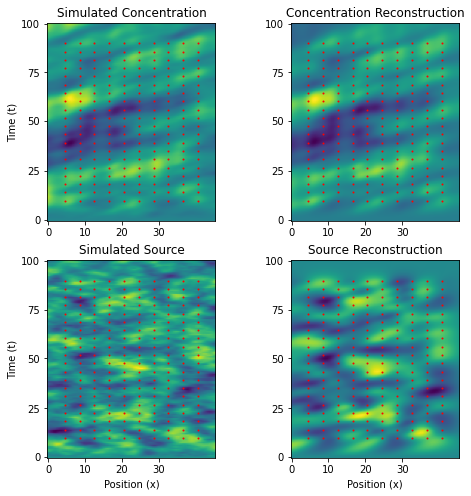

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(wt[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.title("Simulated Concentration")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,2)
plt.imshow(mean[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.title("Concentration Reconstruction")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,3)
plt.imshow(source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("Simulated Source")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,4)
plt.imshow(mean_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("Source Reconstruction")
plt.xlabel("Position (x)")
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.show()

In [27]:
# calculate a simultaneous confidence interval from a sparse precision matrix
def simultaneous_confint_prec(fac,dim,num_sim,R=None,p=0.05):

	chi2k = stats.chi2(df=dim)
	thresh = chi2k.ppf(1-p)

	sims = random.normal(size=(num_sim,dim))
	sim_mags = np.sum(sims**2,axis=1)
	for i in range(num_sim):
		sims[i,:] = fac.apply_Pt(fac.solve_Lt(sims[i,:],use_LDLt_decomposition=False))
	if R is not None:
		for i in range(num_sim):
			sims[i,:] = R @ sims[i,:]
	std = np.std(sims,axis=0)

	sims_scaled = sims*thresh/std
	for i in range(num_sim):
		sims_scaled[i,:] /= sim_mags[i]

	return std*np.max(sims_scaled)

sim_confint_proc_vec = simultaneous_confint_prec(Qupost_fac,N_t*N_x,1000,p=0.05)
sim_confint_source_vec = simultaneous_confint_prec(Qupost_fac,N_t*N_x,1000,p=0.05,R=R_proc)
sim_confint_proc = sim_confint_proc_vec.reshape((N_t,N_x))
sim_confint_source = sim_confint_source_vec.reshape((N_t,N_x))
print(np.max((mean-wt)/sim_confint_proc))
print(np.max((mean_source-source)/sim_confint_source))

0.6379278032571497
0.8661663534188987


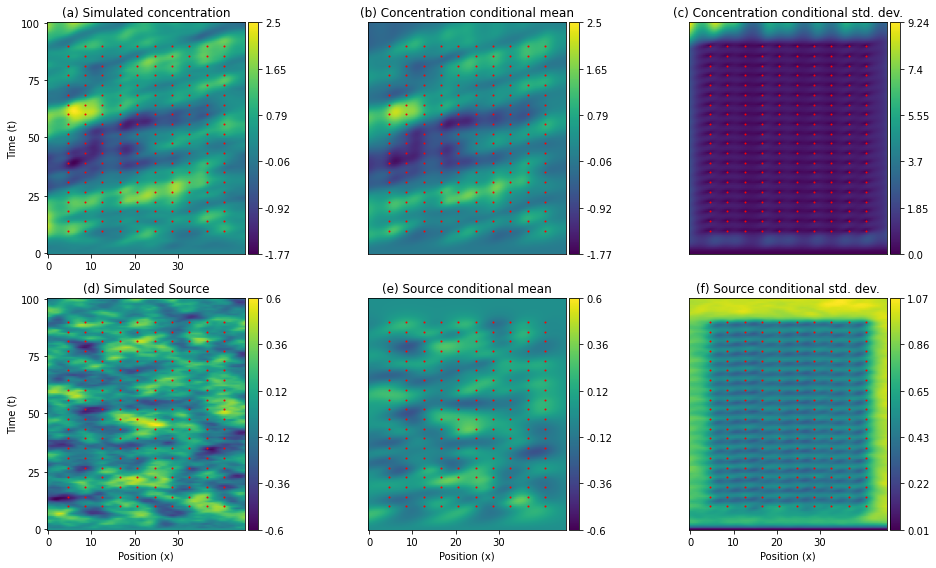

In [28]:
plt.figure(figsize=(14,8))

ax = plt.subplot(2,3,1)
plt.imshow(wt[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(a) Simulated concentration")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(wt),np.max(wt),6,endpoint=True),2))

ax = plt.subplot(2,3,2)
plt.imshow(mean[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))],vmin=np.min(wt),vmax=np.max(wt))
plt.title("(b) Concentration conditional mean")
plt.tick_params(axis="both",which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(wt),np.max(wt),6,endpoint=True),2))

ax = plt.subplot(2,3,3)
plt.imshow(sim_confint_proc[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(c) Concentration conditional std. dev.")
plt.tick_params(axis="both",which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(sim_confint_proc),np.max(sim_confint_proc),6,endpoint=True),2))

ax = plt.subplot(2,3,4)
plt.imshow(source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(d) Simulated Source")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(source),np.max(source),6,endpoint=True),2))

ax = plt.subplot(2,3,5)
plt.imshow(mean_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))],vmin=np.min(source),vmax=np.max(source))
plt.title("(e) Source conditional mean")
plt.xlabel("Position (x)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.tick_params(axis="y",which="both",left=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(source),np.max(source),6,endpoint=True),2))

ax = plt.subplot(2,3,6)
plt.imshow(sim_confint_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(f) Source conditional std. dev.")
plt.xlabel("Position (x)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.tick_params(axis="y",which="both",left=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(sim_confint_source),np.max(sim_confint_source),6,endpoint=True),2))

plt.tight_layout()
plt.show()

In [29]:
np.max(wt)

2.5020452212493653